# Predictive analysis using Time Series models 

#### In this notebook, the time series models, namely ARIMA and SARIMA, are used for forcasting the values of the stock prices of Google and Microsoft

### Time Series Forecasting



----

#### AutoRegressive Integrated Moving Average (ARIMA) model

AR - autoregressive (uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”)

I - integrated (e.g. differencing - subtracts an observation from an observation at the previous time step)

MA - moving average (exploits the relationship between the residual error and the observations)

----

#### Seasonal Auto - Regressive Integrated Moving Average (SARIMA) model

s - component represents seasonality (if our data has any seasonal patterns)

AR - autoregressive (uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”)

I - integrated (e.g. differencing - subtracts an observation from an observation at the previous time step)

MA - moving average (exploits the relationship between the residual error and the observations)

---

#### Steps of the analysis
1. Check for Stationarity - whether data has any trends or seasonal effects - Augmented Dickey Fuller (ADF) test, whichh is a statistical unit root test that tests the null hypothesis
  
The null hypothesis of the ADF test is that the time series is non-stationary:

    * p-value < 0.05 then series is stationary
    * p-value > 0.05 then series is non-stationary.


2. If data is not stationary, to transform a non-stationary series to a statiory series we can do the following:

    * differencing
    * log transform
  
3. Inspect Autocorrelation and Partial Autocorrelation plots to determine the order of q and p 
    

4. Building model ARIMA(p, d, q)
 
   * p is the order of AR - check the plot of PACF (partial autocorrelations) to determine significant lags
  
   * d is the number of differencing (degree of differencing)
     
   * q is the order of MA - check the plot of ACF (partial autocorrelations) to determine significant lags
     


5. To forecast
    * split data (train:test) data - here points are used to represent 2 weeks of predictions (to do a 80:20 split, need to adjust the relevant function or do it manually)
    * use .predict() method
    * evaluate the model
    
---




### *To note:

1. For the analysis, daily adjusted close stock market prices for Google and Microsoft were used
2. Given that the trading takes place during working week only - missing data for the weekends have been imputed using linear interpolation
3. All (own) relevant functions used in this project are imported from peredictive_analysis_functions.py
4. The predictions using the given models were not very satisfactory - further research must be carried out to improve the performance

### Importing the libraries and packages

In [1]:
# Import required packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# To reduce the printing of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Importing models and tools from the statsmodels library
from statsmodels.tsa.stattools import adfuller  # test for stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # determine p and q arguments of ARIMA(p,q,d)
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Importing models and tools from the pmdarima package
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs

# Accuracy metrics from Scikit-learn to evauate model's performance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


# Import own functions
from peredictive_analysis_functions import read_in_data, prep_series_for_forecasting, stationarity_check, differencing
from peredictive_analysis_functions import split_train_test, ARIMA_forecasting, SARIMA_forecasting, plot_train_test_predictions_ARIMA
from peredictive_analysis_functions import plot_train_test_predictions_SARIMA, model_eval


# **************** Predictive Analysis for Google ****************

### Creating a folder and path for saving figures

In [2]:
# Create PDFs 
makePDF = True
if( makePDF ):
    # Make sure we *have a Figures directory
    import pathlib
    pathlib.Path('Fig_Pred_Goog').mkdir(exist_ok=True)

### 1. Reading in the data and creating a series with the daily dates as index

In [3]:
# Reading in the data
data_file_name = 'interpolated_7_adj_close.csv'
df = read_in_data(data_file_name)

# Preparing the series for analysis and for forecast
feature_name = 'goog_adj_close'
df, series = prep_series_for_forecasting(df, feature_name)

### 2.Plotting the stock market prices

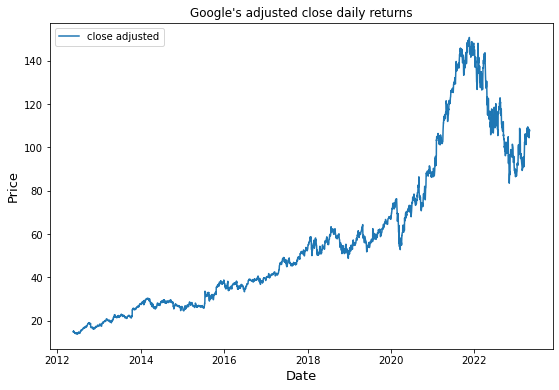

In [4]:
# Plot the series
plt.rcParams["figure.figsize"] = (9, 6)
plt.plot(series, label = 'close adjusted')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Price', fontsize = 13)
plt.title('Google\'s adjusted close daily returns')
         
plt.legend()

plt.show()

### 3. Checking if the series is stationary, i.e. the mean and the variance are close to constant 

In [5]:
# The ADF test 
stationarity_check(series)

ADF Statistic: -0.601052
p-value: 0.870744

The number of differencing required for this data to be stationary is 1.


### 4. Difference the data if required

In [6]:
# Differenced data
diff_data = differencing(series)
diff_data

timestamp
2012-05-19    0.113833
2012-05-20    0.113833
2012-05-21    0.113833
2012-05-22   -0.331500
2012-05-23    0.215700
                ...   
2023-04-27    3.920000
2023-04-28   -0.150000
2023-04-29   -0.170000
2023-04-30   -0.170000
2023-05-01   -0.170000
Freq: D, Name: goog_adj_close, Length: 4000, dtype: float64

In [7]:
# Checking whether the differenced data is stationary using the ADF test 
stationarity_check(diff_data)

ADF Statistic: -12.482520
p-value: 0.000000

The number of differencing required for this data to be stationary is 0.


### 5. Determine the order of AR(p) and MA(q) components using Partial Autocorrelation and Autocorrelation plots respectively

##### 5.1. ACF plot - use differenced data or original series (if original series is stationary)

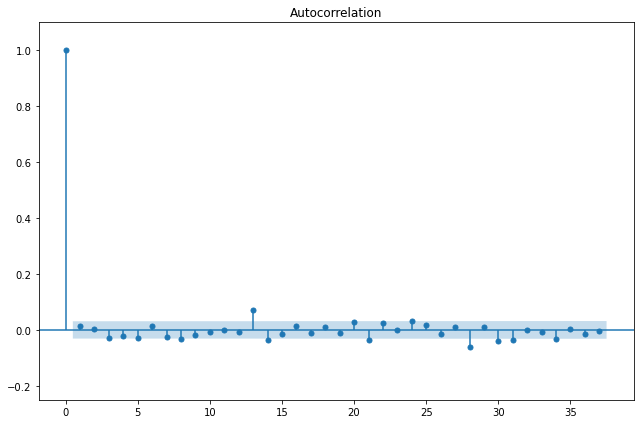

In [8]:
# ACF plot to determine order of MA component
plt.rcParams["figure.figsize"] = (9, 6)
plot_acf(diff_data)
plt.ylim(-0.25, 1.1)
plt.savefig('Fig_Pred_Goog/ACF.pdf')

plt.tight_layout()
plt.show()

##### 5.2. PACF plot use differenced data or original series (if original series is stationary)

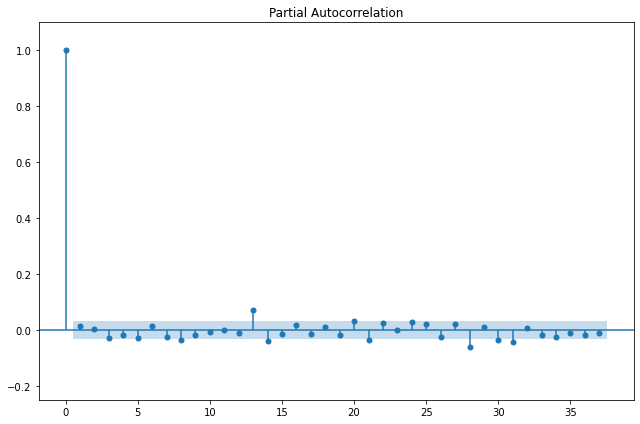

In [9]:
# PACF plot to determine order of AR component
plt.rcParams["figure.figsize"] = (9, 6)
plot_pacf(diff_data)
plt.ylim(-0.25, 1.1)
plt.savefig('Fig_Pred_Goog/PACF.pdf')

plt.tight_layout()
plt.show()


### 6. Explore (separate) trend and seasonality

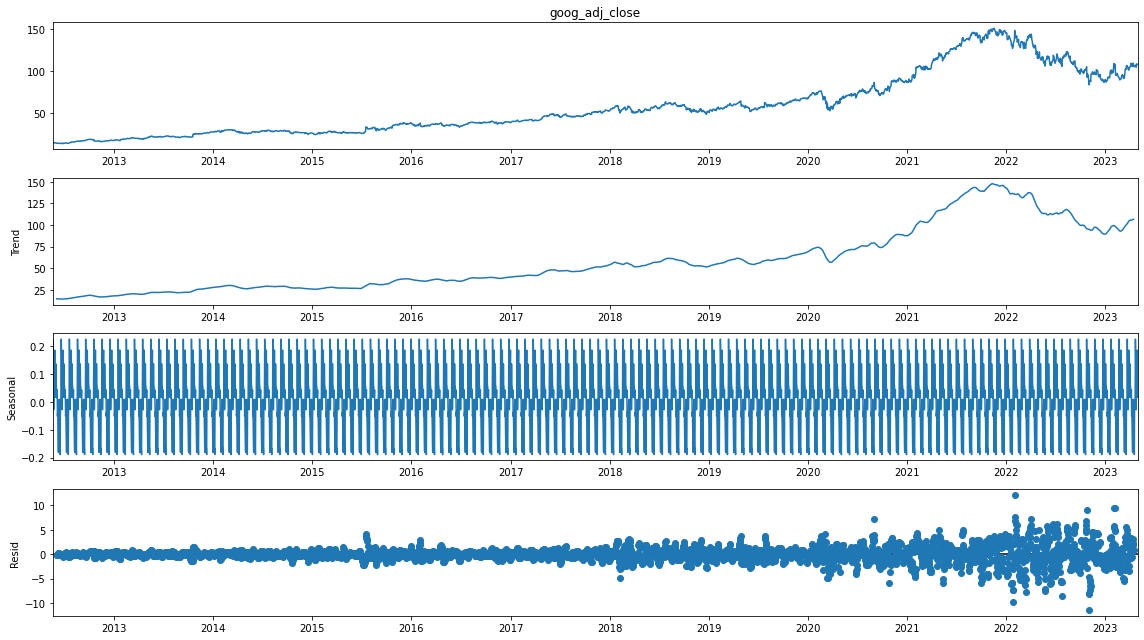

In [10]:
plt.rcParams["figure.figsize"] = (16,9)

result = seasonal_decompose(series, model = 'additive', period = 30)  #model = 'multiplicative'
result.plot()

plt.show()

### 7. Split the data into train and test datasets

In [11]:
# Train/test datasets
n = 14
train, test = split_train_test(series, n)
print(train.shape)
print(test.shape)

(3987,)
(14,)


### 7. Implementing ARIMA(p,d,q) model

In [12]:
# For plotting

# Names of the tech companies 
company_name_lst = ['Google', 'Microsoft']

# Names of the models available
model_lst = ['AR', 'MA', 'ARIMA', 'SARIMA']

#### 7.1. Training the model and making predictions using ARIMA(3,1,3) and ARIMA(13,1,13) these values for p and q seem to be significant from ACF and PACF plots

#### 7.1.1. ARIMA(3,1,3)

                               SARIMAX Results                                
Dep. Variable:         goog_adj_close   No. Observations:                 3987
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5631.210
Date:                Sun, 28 May 2023   AIC                          11276.419
Time:                        08:34:58   BIC                          11320.453
Sample:                    05-18-2012   HQIC                         11292.031
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6874      0.182      3.784      0.000       0.331       1.043
ar.L2          0.5176      0.266      1.944      0.052      -0.004       1.040
ar.L3         -0.4433      0.183     -2.418      0.0

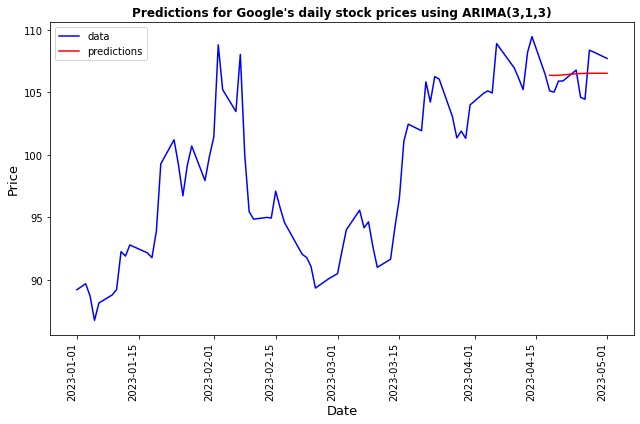

The evaluation of the given ARIMA model:

 R^2 score is: 0.054924

 The MSE is: 1.685360


In [13]:
# ARIMA(3,1,3) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots
p = 3
d = 1
q = 3

predictions = ARIMA_forecasting(train, test, p, d, q)

company_name = company_name_lst[0]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.1.2. ARIMA(13,1,13)

/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         goog_adj_close   No. Observations:                 3987
Model:               ARIMA(13, 1, 13)   Log Likelihood               -5599.622
Date:                Sun, 28 May 2023   AIC                          11253.244
Time:                        08:35:12   BIC                          11423.089
Sample:                    05-18-2012   HQIC                         11313.460
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2279      0.356     -0.641      0.522      -0.925       0.469
ar.L2          0.1184      0.391      0.302      0.762      -0.649       0.885
ar.L3          0.2005      0.249      0.805      0.4

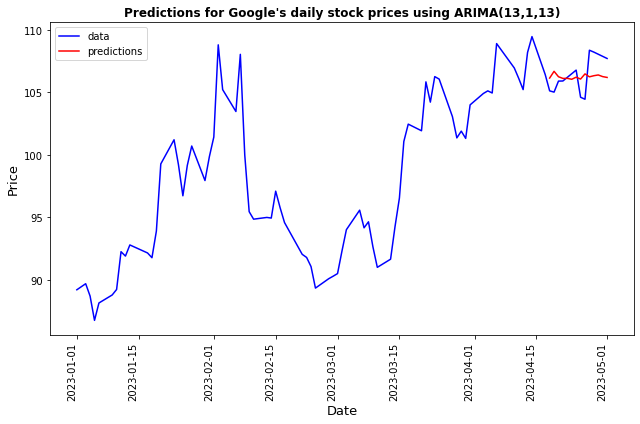

The evaluation of the given ARIMA model:

 R^2 score is: -0.060883

 The MSE is: 1.891880


In [14]:
# ARIMA(13,1,13) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots
p = 13
d = 1
q = 13

predictions = ARIMA_forecasting(train, test, p, d, q)

company_name = company_name_lst[0]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.2. Training ARIMA model using a grid search to detect the optimal parameters for the model

In [15]:
# Code to determine optimal combinations for SARIMA model
# The code in this cell can be found on the website using the 
# following url:

# In this code parameters for ARIMA model are determined by 
# trying different combinations of parameters and comparing the MSE of the model

# Range of values for the parameters - choices are guided by the ACF and PACF plots


# p_values = [0, 3, 5, 13]
# d_values = range(0, 2)
# q_values = [0, 3, 5, 13]


# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p,d,q)
#             warnings.filterwarnings("ignore")
#             model = ARIMA(train, order=order).fit()
#             predictions = model.predict(start=len(train), end=len(train) + len(test) - 1)
#             error = mean_squared_error(test, predictions)
#             print('ARIMA%s MSE=%.3f' % (order,error))

/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         goog_adj_close   No. Observations:                 3987
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -5626.950
Date:                Sun, 28 May 2023   AIC                          11275.901
Time:                        08:35:17   BIC                          11345.097
Sample:                    05-18-2012   HQIC                         11300.433
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1276      0.156      0.817      0.414      -0.178       0.434
ar.L2          0.2152      0.174      1.236      0.216      -0.126       0.556
ar.L3          0.3952      0.116      3.395      0.0

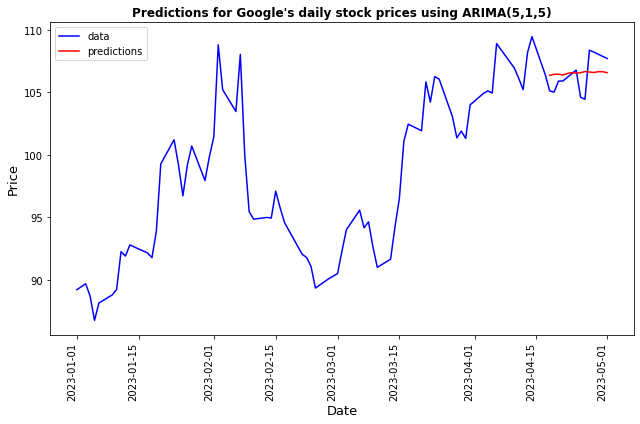

The evaluation of the given ARIMA model:

 R^2 score is: 0.060133

 The MSE is: 1.676071


In [16]:
# ARIMA(5,1,5) model appears to be having the lowest MSE=1.676 using the observations from the gridsearch
# seem to be signifficanft on both plots

p = 5
d = 1
q = 5

# Call the function to implement the model
predictions = ARIMA_forecasting(train, test, p, d, q)


company_name = company_name_lst[0]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.2. Training ARIMA model using auto_arima form pmdarima which detects the optimal parameters for the model

In [17]:
# Auto_arima
auto_arima = auto_arima(train, stepwise=False, start_p=0, 
                        start_q=0,
                        max_p=13, 
                        max_d=1, 
                        max_q=13, 
                        max_order=10,
                        seasonal=False)
auto_arima


/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: 

ARIMA(order=(3, 1, 5), scoring_args={}, suppress_warnings=True)

/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         msft_adj_close   No. Observations:                 3987
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -8607.107
Date:                Sun, 28 May 2023   AIC                          17232.214
Time:                        08:49:44   BIC                          17288.829
Sample:                    05-18-2012   HQIC                         17252.286
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1567      0.182     -0.862      0.389      -0.513       0.200
ar.L2         -0.7201      0.056    -12.935      0.000      -0.829      -0.611
ar.L3         -0.3600      0.159     -2.258      0.0

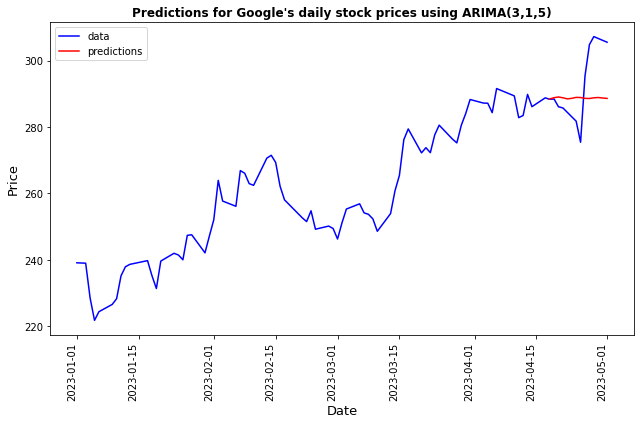

The evaluation of the given ARIMA model:

 R^2 score is: -0.147409

 The MSE is: 132.328765


In [43]:
# ARIMA(2,1,2) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

p = 3
d = 1
q = 5

predictions = ARIMA_forecasting(train, test, p, d, q)

# Calling the plotting function
company_name = company_name_lst[0]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)


### 8. Implementing SARIMA(p,d,q)(P,D,Q,m) model

This model has two sets of orders:

* order for regular components of ARIMA model (p,d,q) 
     
* order for the seasonal components (P,D,Q,m), where m tells us how many data points per year we have, e.g. for monthly data, m = 12

#### 8.1. Estimate the parameters for SARIMA model using auto_arima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41223D+00    |proj g|=  1.59763D-02


 This problem is unconstrained.



At iterate    5    f=  1.41193D+00    |proj g|=  4.41418D-03

At iterate   10    f=  1.41147D+00    |proj g|=  6.81789D-03

At iterate   15    f=  1.41145D+00    |proj g|=  5.83378D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.834D-07   1.411D+00
  F =   1.4114516677400448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                      goog_adj_close   No. Observations:                 3987
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   

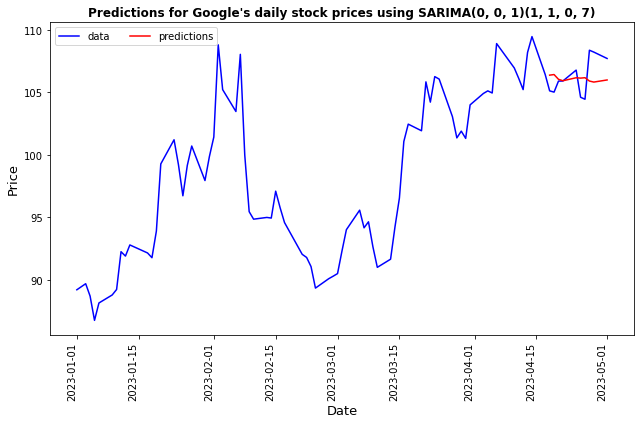

The evaluation of the given SARIMA model:

 R^2 score is: -0.310175

 The MSE is: 2.336444


In [19]:
# Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 1
D = 0
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)


company_name = company_name_lst[0]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)


#### 8.2. Estimate the parameters for SARIMA model using grid search, the code for which is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/ 

In [20]:
# # The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/

# from itertools import product
# from tqdm import tqdm_notebook

# ps = range(0, 3)
# qs = range(0, 3)

# p = 0
# d = 1 
# q = 0

# Ps = range(0, 3)
# Qs = range(0, 3)

# P = 0
# D = 1
# Q = 0
# s = 7

# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

In [21]:
# # The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
# def gs_arima(series, parameters_list, d, D, s, opt_method='powell'):
#     """
#         Return dataframe with parameters and corresponding AIC, and the best model according to AIC
        
#         parameters_list - list with (p, q, P, Q) tuples
#         d - integration order in ARIMA model
#         D - seasonal integration order 
#         s - length of season
#     """
    
#     results = []
#     models = {}
#     best_aic = float("inf")

#     for param in parameters_list:
#         # we need try-except because on some combinations model might fail to converge
#         try:
#             model = SARIMAX(
#                 series, 
#                 order=(param[0], d, param[1]), 
#                 seasonal_order=(param[2], D, param[3], s)).fit(method=opt_method, disp=False)
#         except:
#             continue

#         aic = model.aic
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])

#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
#     return result_table, best_model

In [22]:
# # The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
# result_table, best_model = gs_arima( train, parameters_list, d, D, s)

In [23]:
# # The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
# result_table.head(10)

In [24]:

# parameters	aic
# 0	(0, 0, 2, 1)	11293.358940
# 1	(1, 0, 2, 1)	11294.508038
# 2	(0, 1, 2, 1)	11294.518322
# 3	(0, 2, 2, 1)	11296.336101
# 4	(2, 0, 2, 1)	11296.384973
# 5	(1, 1, 2, 1)	11296.490680
# 6	(2, 1, 2, 1)	11297.047476
# 7	(0, 0, 0, 2)	11297.761024
# 8	(0, 0, 1, 1)	11298.041461
# 9	(1, 2, 2, 1)	11298.055674


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41144D+00    |proj g|=  1.69614D-02


 This problem is unconstrained.



At iterate    5    f=  1.41125D+00    |proj g|=  2.91746D-03

At iterate   10    f=  1.41105D+00    |proj g|=  4.91313D-03

At iterate   15    f=  1.41101D+00    |proj g|=  2.82516D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   2.825D-06   1.411D+00
  F =   1.4110129461178904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                      goog_adj_close   No. Observations:                 3987
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   

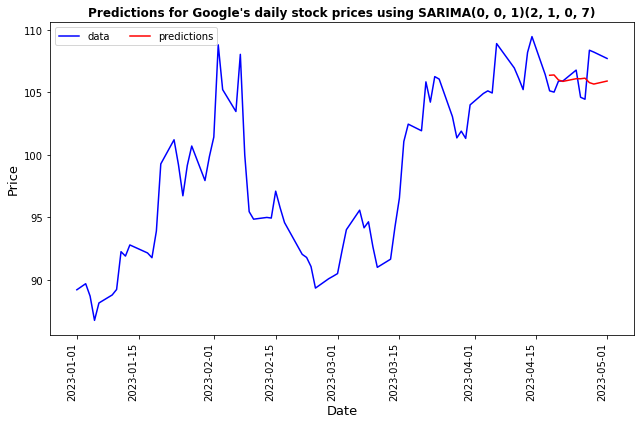

The evaluation of the given SARIMA model:

 R^2 score is: -0.412900

 The MSE is: 2.519633


In [25]:
# # Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 2
D = 0
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)


company_name = company_name_lst[0]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50147D+00    |proj g|=  1.07596D-01


 This problem is unconstrained.



At iterate    5    f=  1.42710D+00    |proj g|=  5.28976D-02

At iterate   10    f=  1.41695D+00    |proj g|=  1.22909D-02

At iterate   15    f=  1.41541D+00    |proj g|=  2.11749D-03

At iterate   20    f=  1.41528D+00    |proj g|=  1.31557D-03

At iterate   25    f=  1.41527D+00    |proj g|=  1.53165D-04

At iterate   30    f=  1.41527D+00    |proj g|=  9.34304D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     44      1     0     0   1.110D-04   1.415D+00
  F =   1.4152696107865095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Resul

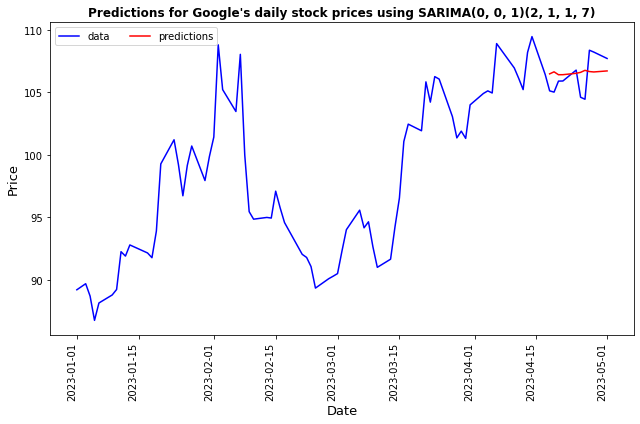

The evaluation of the given SARIMA model:

 R^2 score is: 0.030190

 The MSE is: 1.729469


In [26]:
# # Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 2
D = 1
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)

company_name = company_name_lst[0]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Goog'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)

# ********************  Predictive Analysis for Microsoft ******************** 

### Creating a folder and path for saving figures

In [27]:
# Create PDFs 
makePDF = True
if( makePDF ):
    # Make sure we *have a Figures directory
    import pathlib
    pathlib.Path('Fig_Pred_Msft').mkdir(exist_ok=True)

### 1. Reading in the data and creating a series with the daily dates as index

In [28]:
# Reading in the data
data_file_name = 'interpolated_7_adj_close.csv'
df = read_in_data(data_file_name)

# Preparing the series for analysis and for forecast
feature_name = 'msft_adj_close'
df, series = prep_series_for_forecasting(df, feature_name)

### 2.Plotting the stock market prices

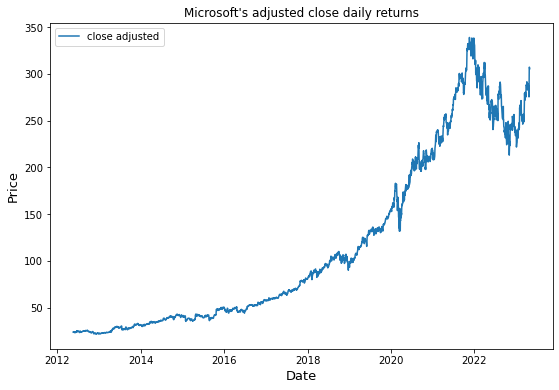

In [29]:
# Plot the series
plt.rcParams["figure.figsize"] = (9, 6)
plt.plot(series, label = 'close adjusted')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Price', fontsize = 13)
plt.title('Microsoft\'s adjusted close daily returns')
         
plt.legend()

plt.show()

### 3. Checking if the series is stationary, i.e. the mean and the variance are close to constant 

In [30]:
# The ADF test 
stationarity_check(series)

ADF Statistic: 0.664535
p-value: 0.989103

The number of differencing required for this data to be stationary is 1.


### 4. Difference the data if required

In [31]:
# Differenced data

diff_data = differencing(series)
diff_data

timestamp
2012-05-19    0.129633
2012-05-20    0.129633
2012-05-21    0.129633
2012-05-22    0.008100
2012-05-23   -0.526700
                ...   
2023-04-27    9.460000
2023-04-28    2.430000
2023-04-29   -0.566667
2023-04-30   -0.566667
2023-05-01   -0.566667
Freq: D, Name: msft_adj_close, Length: 4000, dtype: float64

In [32]:
# Checking whether the differenced data is stationary using the ADF test 
stationarity_check(diff_data)

ADF Statistic: -14.274640
p-value: 0.000000

The number of differencing required for this data to be stationary is 0.


### 5. Determine the order of AR(p) and MA(q) components using Partial Autocorrelation and Autocorrelation plots respectively

##### 5.1. ACF plot

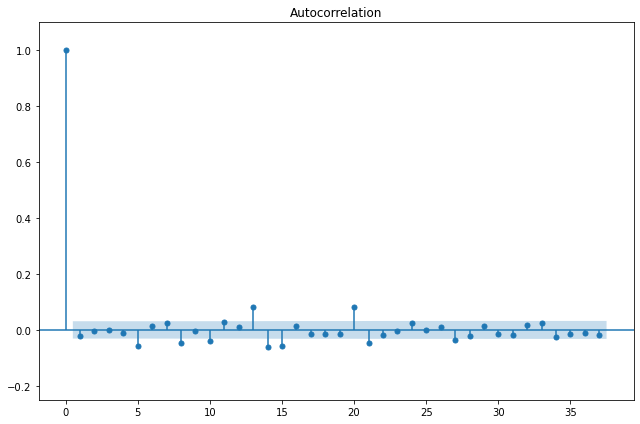

In [33]:
# ACF plot to determine order of MA component
plt.rcParams["figure.figsize"] = (9, 6)
plot_acf(diff_data)
plt.ylim(-0.25, 1.1)
plt.savefig('Fig_Pred_Msft/ACF.pdf')

plt.tight_layout()
plt.show()

##### 5.2. PACF plot

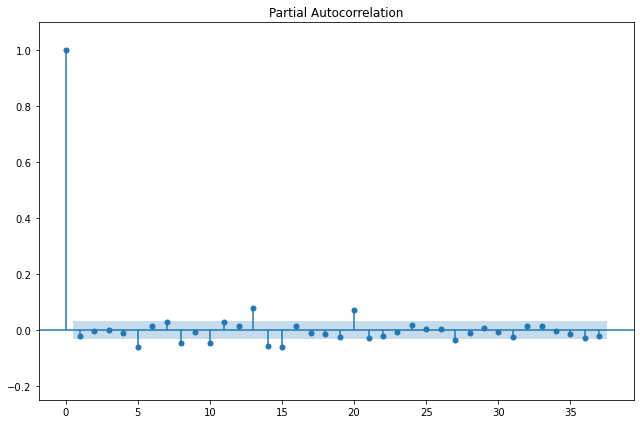

In [34]:
# PACF plot to determine order of AR component
plt.rcParams["figure.figsize"] = (9, 6)
plot_pacf(diff_data)
plt.ylim(-0.25, 1.1)
plt.savefig('Fig_Pred_Msft/PACF.pdf')

plt.tight_layout()
plt.show()


### 6. Explore (separate) trend and seasonality

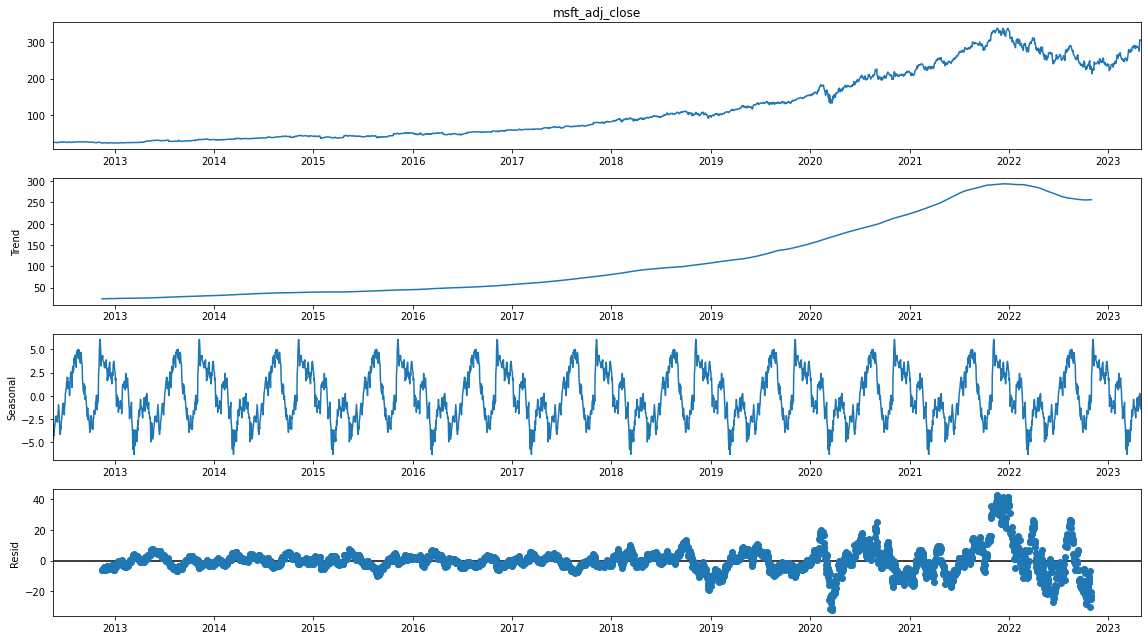

In [35]:
plt.rcParams["figure.figsize"] = (16,9)

result = seasonal_decompose(series, model = 'additive', period = 365)  #model = 'multiplicative'
result.plot()

plt.show()

### 7. Split the data into train and test datasets

In [36]:
# Train/test datasets
n = 14
train, test = split_train_test(series, n)
print(train.shape)
print(test.shape)

(3987,)
(14,)


### 7. Implementing ARIMA(p,d,q) model

In [37]:
# For plotting

# Names of the tech companies 
company_name_lst = ['Google', 'Microsoft']

# Names of the models available
model_lst = ['AR', 'MA', 'ARIMA', 'SARIMA']

#### 7.1. Training the model and making predictions using ARIMA(3,1,3) and ARIMA(13,1,13) these values for p and q seem to be significcant from ACF and PACF plots

#### 7.1.1. ARIMA(3,1,3)

                               SARIMAX Results                                
Dep. Variable:         msft_adj_close   No. Observations:                 3987
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -8615.447
Date:                Sun, 28 May 2023   AIC                          17244.894
Time:                        08:38:43   BIC                          17288.927
Sample:                    05-18-2012   HQIC                         17260.505
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0255      0.328     -0.078      0.938      -0.668       0.617
ar.L2         -0.7187      0.175     -4.106      0.000      -1.062      -0.376
ar.L3          0.4994      0.324      1.543      0.1

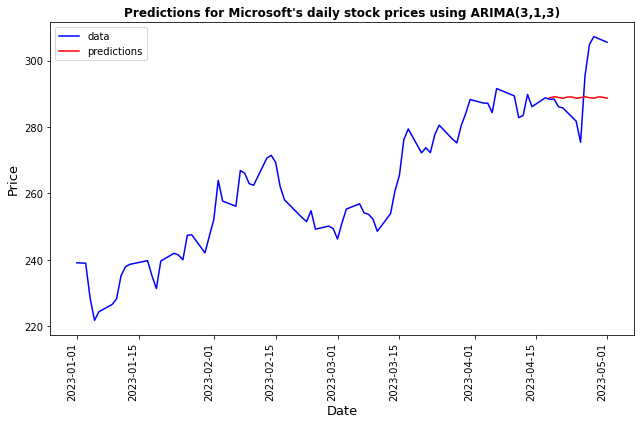

The evaluation of the given ARIMA model:

 R^2 score is: -0.133080

 The MSE is: 130.676272


In [38]:
# ARIMA(3,1,3) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots
p = 3
d = 1
q = 3

# Calling the function to train the model and obtain predictions
predictions = ARIMA_forecasting(train, test, p, d, q)

# Calling the plotting function
company_name = company_name_lst[1]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.1.2. ARIMA(13,1,13)

/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         msft_adj_close   No. Observations:                 3987
Model:               ARIMA(13, 1, 13)   Log Likelihood               -8579.426
Date:                Sun, 28 May 2023   AIC                          17212.852
Time:                        08:39:00   BIC                          17382.696
Sample:                    05-18-2012   HQIC                         17273.068
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5401      0.226     -2.387      0.017      -0.984      -0.097
ar.L2         -0.2600      0.283     -0.919      0.358      -0.815       0.295
ar.L3       8.862e-05      0.294      0.000      1.0

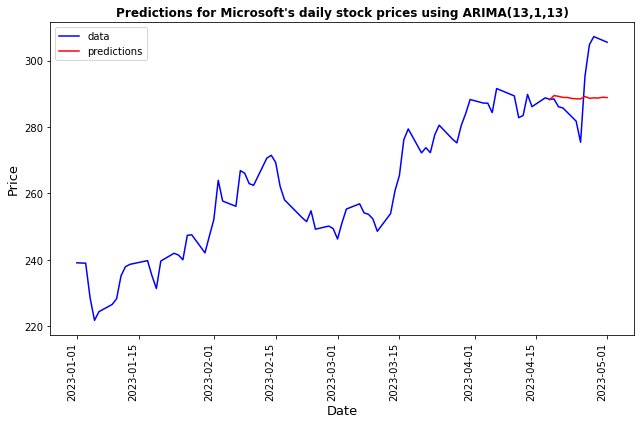

The evaluation of the given ARIMA model:

 R^2 score is: -0.128319

 The MSE is: 130.127193


In [39]:
# ARIMA(13,1,13) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots
p = 13
d = 1
q = 13

# Calling the function to train the model and obtain predictions
predictions = ARIMA_forecasting(train, test, p, d, q)


company_name = company_name_lst[1]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.2. Training ARIMA model using a grid search to detect the optimal parameters for the model

In [40]:
# Code to determine optimal combinations for SARIMA model
# The code in this cell can be found on the website using the 
# following url:

# In this code parameters for ARIMA model are determined by 
# trying different combinations of parameters and comparing the MSE of the model

# Range of values for the parameters - choices are guided by the ACF and PACF plots


# p_values = [0, 3, 5, 13]
# d_values = range(0, 2)
# q_values = [0, 3, 5, 13]


# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p,d,q)
#             warnings.filterwarnings("ignore")
#             model = ARIMA(train, order=order).fit()
#             predictions = model.predict(start=len(train), end=len(train) + len(test) - 1)
#             error = mean_squared_error(test, predictions)
#             print('ARIMA%s MSE=%.3f' % (order,error))

/Users/irynadzhyhita-khan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         msft_adj_close   No. Observations:                 3987
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -8600.627
Date:                Sun, 28 May 2023   AIC                          17223.254
Time:                        08:39:04   BIC                          17292.449
Sample:                    05-18-2012   HQIC                         17247.786
                         - 04-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5474      0.082     -6.636      0.000      -0.709      -0.386
ar.L2         -0.1584      0.113     -1.400      0.162      -0.380       0.063
ar.L3         -0.1428      0.111     -1.285      0.1

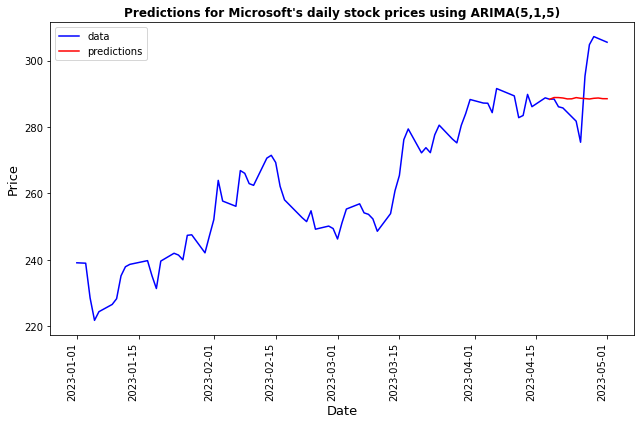

The evaluation of the given ARIMA model:

 R^2 score is: -0.157416

 The MSE is: 133.482855


In [41]:
# ARIMA(5,1,5) model appears to be having the lowest MSE=1.676 using the observations from the gridsearch
# seem to be signifficanft on both plots

p = 5
d = 1
q = 5

# Calling the function to train the model and obtain predictions
predictions = ARIMA_forecasting(train, test, p, d, q)

company_name = company_name_lst[1]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)

#### 7.2. Training ARIMA model using auto_arima form pmdarima which detects the optimal parameters for the model

In [42]:
# Auto_arima
auto_arima = auto_arima(train, stepwise=False, start_p=0, start_q=0, seasonal=False)
auto_arima

TypeError: 'ARIMA' object is not callable

In [ ]:
train.shape

In [ ]:
# ARIMA(2,1,2) model using the observations from PACF and ACF plots where lag 3, 5, and 13
# seem to be signifficanft on both plots

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

p = 2
d = 1
q = 2

# Calling the function to train the model and obtain predictions
predictions = ARIMA_forecasting(train, test, p, d, q)


company_name = company_name_lst[1]
model_name = model_lst[2]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_ARIMA(series, train, test, predictions, company_name, model_name, p, d, q, fig_folder)

# Evaluating the model performance
ARIMA_eval = model_eval(train, test, predictions, company_name, model_name)


### 8. Implementing SARIMA(p,d,q)(P,D,Q,m) model

This model has two sets of orders:

* order for regular components of ARIMA model (p,d,q) 
     
* order for the seasonal components (P,D,Q,m), where m tells us how many data points per year we have, e.g. for monthly data, m = 12

#### 8.1. Estimate the parameters for SARIMA model using auto_arima

In [ ]:
# Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 1
D = 0
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)


company_name = company_name_lst[1]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)


#### 8.2. Estimate the parameters for SARIMA model using grid search, the code for which is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/ 

In [ ]:
# The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/

from itertools import product
from tqdm import tqdm_notebook

ps = range(0, 3)
qs = range(0, 3)

p = 0
d = 1 
q = 0

Ps = range(0, 3)
Qs = range(0, 3)

P = 0
D = 1
Q = 0
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
# The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
def gs_arima(series, parameters_list, d, D, s, opt_method='powell'):
    """
        Return dataframe with parameters and corresponding AIC, and the best model according to AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    models = {}
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model might fail to converge
        try:
            model = SARIMAX(
                series, 
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], s)).fit(method=opt_method, disp=False)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_model

In [ ]:
# The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
result_table, best_model = gs_arima( train, parameters_list, d, D, s)

In [ ]:
# The code in this cell is from https://mins.space/blog/2020-09-14-tuning-forecasting-sarima-models/
result_table.head(10)

In [ ]:

# parameters	aic
# 0	(0, 0, 2, 1)	11293.358940
# 1	(1, 0, 2, 1)	11294.508038
# 2	(0, 1, 2, 1)	11294.518322
# 3	(0, 2, 2, 1)	11296.336101
# 4	(2, 0, 2, 1)	11296.384973
# 5	(1, 1, 2, 1)	11296.490680
# 6	(2, 1, 2, 1)	11297.047476
# 7	(0, 0, 0, 2)	11297.761024
# 8	(0, 0, 1, 1)	11298.041461
# 9	(1, 2, 2, 1)	11298.055674


In [ ]:
# # Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 2
D = 0
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)


company_name = company_name_lst[1]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)

In [ ]:
# # Define the parameters of SARIMA model (parameters for each component of the model)
p = 0
d = 1
q = 0
P = 2
D = 1
Q = 1
s = 7


# Call the function to implement the model
predictions = SARIMA_forecasting(train, test, p, d, q, P, D, Q, s)


company_name = company_name_lst[1]
model_name = model_lst[3]
fig_folder = 'Fig_Pred_Msft'

# Plotting predictions
plot_train_test_predictions_SARIMA(series, train, test, predictions, company_name, model_name, p, q, d, P, Q, D, s, fig_folder)


# Evaluating the model performance
model_eval(train, test, predictions, company_name, model_name)